# Cluster Analysis: Lexico-grammatical style (S. 5.2)

In [2]:
from mqdq import babble, elegy

import numpy as np
import pandas as pd
import scipy as sp

import glob
import umap

from collections import Counter

from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.basicConfig(level="INFO")

In [4]:
collection = []

# Several lines need to be manually deleted, because when we make wide vectors
# we treat couplets as a unit (so we must have a matching number of H and P.)
# In some poems, we have corrupt lines, and so we delete the H that matches
# a corrupt P and vice versa.

ep = babble.bookbabs("corpus/OV-epis.xml", name="Ep.")
for b in ep:
    b.author = "Ovid"
collection.extend(ep)

tr = babble.multi_bookbabs(sorted(glob.glob("corpus/OV-tri*.xml")), name="Tr.")
for b in tr:
    b.author = "Ovid"
collection.extend(tr)

am = babble.multi_bookbabs(sorted(glob.glob("corpus/OV-amo*.xml")), name="Am.")
for b in am:
    b.author = "Ovid"
collection.extend(am)

tib = babble.multi_bookbabs(sorted(glob.glob("corpus/TIB-ele*.xml")), name="Tib.")
del tib[1].raw_source[24]
for b in tib:
    b.author = "Tibullus"
collection.extend(tib)

prop = babble.multi_bookbabs(sorted(glob.glob("corpus/PROP-ele*.xml")), name="Prop.")
for b in prop:
    b.author = "Propertius"
del prop[55].raw_source[28]
collection.extend(prop)

cat = babble.bookbabs("corpus/CATVLL-carm.xml", name="Cat.")
cat_ele = [x for x in cat if x.elegiac and len(x) > 20]
for b in cat_ele:
    b.author = "Catullus"
del cat_ele[3].raw_source[46]
collection.extend(cat_ele)

pon = babble.multi_bookbabs(sorted(glob.glob("corpus/OV-pon*.xml")), name="Pont.")
for b in pon:
    b.author = "Ovid"
del pon[1].raw_source[8]
del pon[7].raw_source[18]
collection.extend(pon)

In [5]:
nux = babble.Babbler.from_file("./corpus/OV-nux.xml", name="Nux")
nux.author = "ps-Ovid"
collection.append(nux)
ibis = babble.Babbler.from_file("./corpus/OV-ibis.xml", name="Ibis")
ibis.author = "ps-Ovid"
medi = babble.Babbler.from_file("./corpus/OV-medi.xml", name="Medicamina")
medi.author = "ps-Ovid"
collection.append(medi)
cons = babble.Babbler.from_file("./corpus/OV-cons.xml", name="consolatio")
cons.author = "ps-Ovid"

In [6]:
ll = cons.raw_source
sz = 158
cons_chunks = [ll[i : i + sz] for i in range(0, len(ll), sz)]
cons_ary = []
for i in range(len(cons_chunks)):
    b = babble.Babbler(cons_chunks[i], name=f"Consolatio {i+1}")
    b.author = "ps-Ovid"
    cons_ary.append(b)
collection.extend(cons_ary)
[f"{x.name} - {len(x)}" for x in cons_ary]

['Consolatio 1 - 158', 'Consolatio 2 - 158', 'Consolatio 3 - 158']

In [7]:
ll = ibis.raw_source
sz = 200
# I'm going to declare the "intro" to end at line 66, and the actual 'curse' to
# begin at 67 'di maris et terrae...'. I break them up this way because the
# style is noticably different in the 'intro', whereas the bulk of the rest
# follows standard tropes for invocations (huge amounts of polysyndeton for
# example)
ibis_chunks = [ll[i : i + sz] for i in range(64, len(ll), sz)]
ibis_chunks = [ll[:64]] + ibis_chunks
ibis_ary = []
for i in range(len(ibis_chunks)):
    b = babble.Babbler(ibis_chunks[i], name=f"Ibis {i+1}")
    b.author = "ps-Ovid"
    ibis_ary.append(b)
collection.extend(ibis_ary)
[f"{x.name} - {len(x)}" for x in ibis_ary]

['Ibis 1 - 64', 'Ibis 2 - 200', 'Ibis 3 - 200', 'Ibis 4 - 178']

In [8]:
%load_ext rpy2.ipython

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /Library/Frameworks/R.framework/Resources
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


# Preprocessing - Text Conversion

For this analysis the vectorisation is a little different
to the poetic analysis. The first step is to convert each
poem into a string and perform phonetic conversion. Named
Entity Removal is not done. In the case of the Heroides,
each poem (or each pair, in the Double letters) uses a different
set of characters, so there is little risk that poems might be artificially
clustered with the Heroides simply because of Named Entities.

In [10]:
# Now everything is nicely lowercased with punctuation
# stripped, but retaining linebreaks. Phonetic conversion
# has also been done.

vecs = elegy.vectorise_babs(collection)
# vecs.insert(3, "LEN", [len(b) for b in collection])
vecs

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.0,0.206897,0.068966,0.396552,1.000000,0.094828,4.393948,0.739842,116,0.000000
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.0,0.202703,0.067568,0.337838,1.000000,0.114865,4.071062,1.027448,148,0.000000
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.0,0.116883,0.025974,0.324675,1.000000,0.090909,3.845700,0.484285,154,0.000000
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.0,0.215909,0.045455,0.329545,1.000000,0.073864,3.822098,0.893575,176,0.000000
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.0,0.202532,0.037975,0.341772,1.000000,0.056962,3.727347,0.713715,158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,ps-Ovid,Consolatio,Consolatio 3,0.329114,0.506329,0.658228,0.582278,0.291139,0.594937,0.772152,...,0.0,0.151899,0.037975,0.240506,0.987342,0.202532,4.590044,1.062847,158,0.223589
283,ps-Ovid,Ibis,Ibis 1,0.156250,0.718750,0.562500,0.593750,0.156250,0.562500,0.906250,...,0.0,0.187500,0.000000,0.218750,1.000000,0.109375,3.986751,1.053890,64,0.000000
284,ps-Ovid,Ibis,Ibis 2,0.160000,0.530000,0.620000,0.440000,0.100000,0.580000,0.960000,...,0.0,0.230000,0.060000,0.360000,1.000000,0.130000,4.683774,0.994626,200,0.000000
285,ps-Ovid,Ibis,Ibis 3,0.190000,0.450000,0.730000,0.550000,0.180000,0.730000,0.950000,...,0.0,0.240000,0.050000,0.260000,1.000000,0.060000,4.070276,0.787213,200,0.000000


# Cluster Analysis, using LSA data

Now we filter poems shorter than 20 lines (only 8 works) and then do LSA. This involves:
1. Performing TF-IDF vectorisation, using 2-, 3-, and 4-grams
2. Reducing this high-dimensional data to 50 dimensions using SVD
3. Normalizing the resulting vectors

The process is fairly standard. 50 dimensions is somewhat arbitrary, but is the 'usual' number.

In [20]:
corpus = vecs[vecs.LEN >= 20].reset_index(drop=True)

# Projection Methods

These are Figs 4(b) and 4(c). Both UMAP and t-SNE attempt to produce a 2D figure in which the local manifold properties of the high dimensional space is preserved. In other words, points that are _locally_ 'near' in the original feature space (43 dimensions) should end up locally 'near' in the projection, however the overall topology is somewhat arbitrary; points should cluster correctly, but the distribution of the clusters across the 2D figure may not reflect the true inter-cluster distances. UMAP more or less 'just works' while t-SNE has a `perplexity` parameter which affects the tightness of the clusters (sometimes it is described as broadly analagous to the _k_ in _k_ nearest neighbours.

Neither of these projections produce a result where distances are easy to understand statistically, and so they are qualitative methods (no _P_-values here!).

In [80]:
# Do the actual UMAP projection.

umap_results = pd.DataFrame(corpus[["Poem", "Work", "Author"]])
umapper = umap.UMAP(
    n_neighbors=15,
    # project to 2 dimensions
    n_components=2,
    metric="euclidean",
    # UMAP figures change with every run if not seeded
    random_state=42,
)

scaled = StandardScaler().fit_transform(corpus[corpus.columns[3:]])
# scaled = corpus[corpus.columns[3:]]
u = umapper.fit_transform(scaled)
umap_results["X"], umap_results["Y"] = u[:, 0], u[:, 1]
umap_results

,Poem,Work,Author,X,Y
0,Ep. 1,Ep.,Ovid,11.896687,8.665960
1,Ep. 2,Ep.,Ovid,12.300110,7.862169
2,Ep. 3,Ep.,Ovid,12.212343,8.833221
3,Ep. 4,Ep.,Ovid,11.823921,8.808498
4,Ep. 5,Ep.,Ovid,12.694075,8.452940
...,...,...,...,...,...
274,Consolatio 3,Consolatio,ps-Ovid,11.095967,9.064225
275,Ibis 1,Ibis,ps-Ovid,11.383672,5.739675
276,Ibis 2,Ibis,ps-Ovid,13.267171,7.092294
277,Ibis 3,Ibis,ps-Ovid,12.559730,7.418787


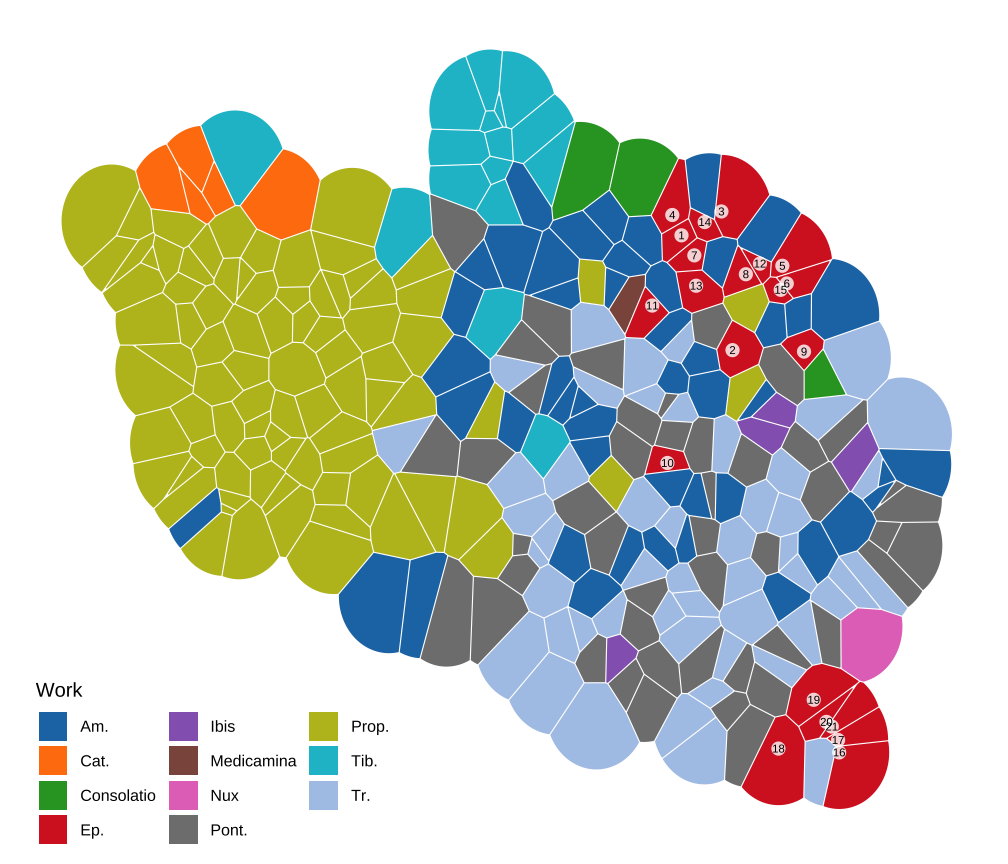

In [81]:
%%R -i umap_results -h 6 -w 7 -u in -r 144

library(ggforce)
library(ggsci)
library(dplyr)
library(stringr)
library(paletteer)


pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", 'grey50', "#A65628")

ep <- umap_results %>% 
    filter(Work=='Ep.') %>%
    mutate(Num = str_extract(Poem, "[0-9]+"))
    
ggplot(data=umap_results,aes(x=X, y=Y)) +
# Voronoi tesselation for everything
geom_voronoi_tile(
    aes(fill = Work, group = -1L, ),
    max.radius = 0.4,
    expand = unit(-0.1, 'mm'), 
    radius = unit(0.1, 'mm')
) +
# Add numbered points just for the Heroides
geom_point(data=ep,color='white',alpha=0.8, size=3,shape=16) +
geom_text(data=ep,aes(label=Num),family='Envy Code R',size=2) +

scale_fill_paletteer_d('ggsci::category20_d3') +
guides(fill = guide_legend(ncol=3,override.aes=list(size=1))) +

theme_minimal() +

theme(
    panel.border = element_blank(),
    legend.position=c(0.2,0.10),
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    text=element_text(size=10, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank()
)

# fn <- "../paper/figures/ele_ngrams_umap.pdf"
# ggsave(fn, dpi=600, width=6, height=6, device=cairo_pdf)


# Bootstrap Consensus Tree

For the idea, see Maciej Eder, (2017) Visualization in stylometry: Cluster analysis using networks, Digital Scholarship in the Humanities, 32 (1), Pages 50–64, https://doi.org/10.1093/llc/fqv061, and see also the implementation in R Stylo. The previous visualisations project from high dimensional _position_ (from the LSA data in 50 dimensions) to 2D. This method constructs many kNN trees from feature subsets, with each tree giving the closest three nodes artificial weights (3, 2, 1). The trees are then aggregated, with the idea that neighbours that are truly related will be close in many of the subset feature universes. The final layout is artificial. Users of `stylo` tend to use Gephi and ForceAtlas2, but in this case I use Fruchterman-Reingold (more or less the same idea) which can be easily done in R with `ggraph`. Once the consensus tree is trimmed, it could be laid out with many different algorithms, and the results are broadly similar (the point positions may change slightly but the overall topological implications don't vary). The advantage of this BCT method is that is shows the strength of the relationships as well as the determined positions.


In [181]:
X, y = (
    pd.DataFrame(StandardScaler().fit_transform(corpus[corpus.columns[3:]])),
    corpus["Poem"],
)

In [182]:
dfs = []
rng = np.random.RandomState(seed=42)
for _ in range(500):
    # Sample 15 random features (columns)
    this_X = X.sample(15, axis=1, random_state=rng)

    # Calculate kNN in that space
    cl = KNeighborsClassifier(n_neighbors=3, metric="cosine")
    cl.fit(this_X, y)
    dists, indices = cl.kneighbors(n_neighbors=3)

    # And build a dataframe from the results
    dicts = []
    for i, node_ary in enumerate(indices):
        for j, node in enumerate(node_ary):
            dicts.append(
                {
                    "from": y[i],
                    "to": y[node],
                    # neighbors are sorted low distance to high
                    # so this gives us the 'inverse rank' ie lowest
                    # distance of n neighbors scores n, next is n-1 etc
                    # this is consistent with the stylo BCT algorithm
                    "weight": (len(node_ary) - j),
                }
            )
    dfs.append(pd.DataFrame(dicts))

# Now aggregate the dataframes, summing the weights for
# identical (directed) edges
graph = pd.concat(dfs).groupby(["from", "to"], as_index=False).agg(sum)
graph_trim = graph.nlargest(int(len(graph) * 0.2), "weight")

In [183]:
graph_trim[graph_trim["from"].str.startswith("Consol")].head(20)

,from,to,weight
6878,Consolatio 1,Ep. 9,443
6985,Consolatio 2,Consolatio 3,380
6975,Consolatio 2,Am. 3 15,334
6897,Consolatio 1,Pont. 4 11,285
7099,Consolatio 3,Consolatio 2,267
7180,Consolatio 3,Tib. 2 5,258
7159,Consolatio 3,Prop. 4 1,251
6984,Consolatio 2,Consolatio 1,218
6854,Consolatio 1,Am. 3 6,213
7169,Consolatio 3,Tib. 1 10,204


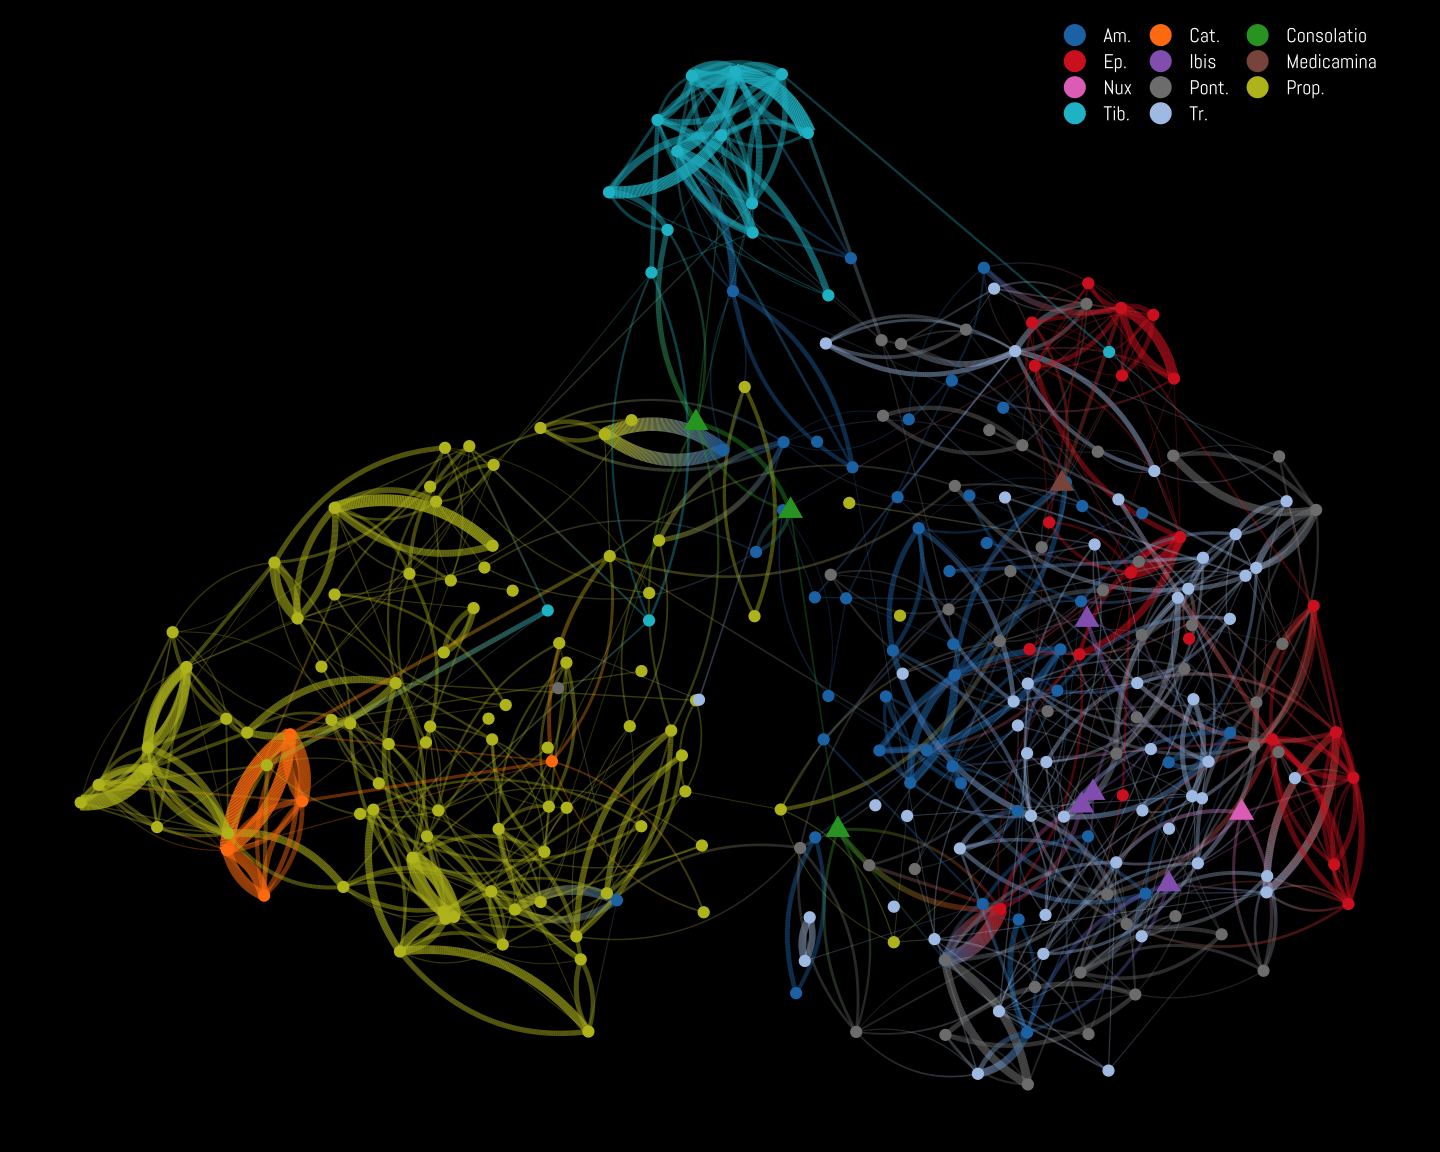

In [186]:
%%R -i graph_trim  -h 8 -w 10 -u in -r 144

# other libraries only need to be loaded once
library(ggraph)
library(tidygraph)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "grey50", "#A65628")
bgcol <- 'black'

# Seed for the layout
set.seed(42)
gr1 <- as_tbl_graph(graph_trim)
# Plot
gr1 %>%
    # Add a node attribute called 'work' which is the poem name with
    # no numbers eg Pont. 3 4 -> Pont.
    activate(nodes) %>%
    mutate(work = str_replace_all(name, '\\s[0-9]+', '')) %>%
    # Layout with Fruchtermann Reingold
    ggraph(layout = 'fr') + 
    # fan2 does curved lines when nodes are linked in both directions
    # and also lets you interpolate colour along the edge
    geom_edge_fan2(
        aes(
            # Aesthetically filter out noisy minor edges.
            # This magic param is determined by experimentation
            # and depends on the number of samples etc.
            # Slightly hacky, but doesn't affect graph layout,
            # just makes the visualisation cleaner.
            filter=weight>=170,
            width=weight,
            color=node.work,
            alpha=weight
        ),
        strength=2,
        show.legend=FALSE
    ) +
    # Normal nodes
    geom_node_point(size = 2.2, aes(color = work), alpha=1) +
    # Special nodes
    geom_node_point(
        aes(
            filter=work %in% c('Nux','Ibis','Consolatio','Medicamina'),
            color=work
        ),
        size=4,
        shape=17,
        show.legend=FALSE
    ) +

    
    scale_fill_paletteer_d('ggsci::category20_d3') +
    scale_colour_paletteer_d('ggsci::category20_d3') +
    scale_edge_color_manual(values=pal_d3("category20")(20)) +
    scale_edge_width(range=c(0.2,4)) +
    scale_edge_alpha(range=c(0.3,1)) +
    
    guides(color=guide_legend(ncol=3,byrow=TRUE, override.aes = aes(size=4.5))) +

    theme_minimal() +
    theme(
        #plot.title = element_text(margin = margin(b = 50)),
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol,color=bgcol),
        legend.title=element_blank(),
        legend.position=c(0.85,0.94),
        #legend.position= 'None',
        legend.text=element_text(size=10,color='white'),
        legend.spacing.x = unit(2, 'mm'),
        legend.spacing.y = unit(-1.5, 'mm'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text = element_text(family="fnt"),
        panel.grid.minor=element_blank(), 
        panel.grid.major=element_blank()
    )

# fn <- "../paper/figures/ele_ngrams_bct_black.pdf"
# ggsave(fn, dpi=600, width=10, height=8, device=cairo_pdf)


In [27]:
test_corpus = corpus[corpus.Author != "ps-Ovid"].reset_index(drop=True)
test_corpus

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.0,0.206897,0.068966,0.396552,1.000000,0.094828,4.393948,0.739842,116,0.000000
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.0,0.202703,0.067568,0.337838,1.000000,0.114865,4.071062,1.027448,148,0.000000
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.0,0.116883,0.025974,0.324675,1.000000,0.090909,3.845700,0.484285,154,0.000000
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.0,0.215909,0.045455,0.329545,1.000000,0.073864,3.822098,0.893575,176,0.000000
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.0,0.202532,0.037975,0.341772,1.000000,0.056962,3.727347,0.713715,158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Ovid,Pont.,Pont. 4 12,0.120000,0.520000,0.720000,0.440000,0.240000,0.560000,0.920000,...,0.0,0.280000,0.040000,0.280000,1.000000,0.100000,3.073075,0.615696,50,0.000000
266,Ovid,Pont.,Pont. 4 13,0.160000,0.600000,0.680000,0.800000,0.280000,0.720000,0.920000,...,0.0,0.240000,0.080000,0.360000,0.880000,0.100000,5.954342,1.723439,50,0.775629
267,Ovid,Pont.,Pont. 4 14,0.129032,0.580645,0.548387,0.645161,0.096774,0.774194,0.903226,...,0.0,0.193548,0.032258,0.193548,0.903226,0.064516,3.314164,1.155196,62,0.591300
268,Ovid,Pont.,Pont. 4 15,0.095238,0.619048,0.666667,0.619048,0.285714,0.666667,0.714286,...,0.0,0.285714,0.095238,0.333333,0.952381,0.119048,3.695211,0.919168,42,0.425918


In [43]:
lenc = LabelEncoder()
labels = lenc.fit_transform(test_corpus.Author)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [44]:
len(labels)

270

In [30]:
from collections import Counter

Counter(labels)

Counter({1: 165, 3: 16, 2: 84, 0: 5})

In [128]:
from ruzicka.Order2Verifier import Order2Verifier



In [129]:
from ruzicka.score_shifting import ScoreShifter
from ruzicka.evaluation import pan_metrics

In [130]:
vectorizer = make_pipeline(
    None,
)

ss = make_pipeline(StandardScaler(with_mean=False))

In [131]:
def make_up_lies(X, y):
    lies_labels = []
    n_labels = max(y) + 1
    for lab in y:
        while True:
            r = np.random.randint(n_labels)
            if r != lab:
                lies_labels.append(r)
                break
    ret_X = np.concatenate([X, X.copy()])
    ret_y = np.concatenate([y, lies_labels])
    ret_gt = np.concatenate([[1.0] * len(X), [0.0] * len(X)])
    return (ret_X, ret_y, ret_gt)

In [132]:
X = test_corpus[test_corpus.columns[3:]]

In [37]:
logger = logging.getLogger("ruzicka")

In [38]:
for handler in logger.handlers:
    handler.setLevel(logging.INFO)

In [39]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

In [40]:
import pkg_resources

pkg_resources.require("ruzicka")[0].version

'0.0.4'

In [164]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
shifter = ScoreShifter()
verifier = Order2Verifier(
    metric="minmax", base="instance", rank=True, nb_bootstrap_iter=2000, rnd_prop=0.5
)
X = test_corpus[test_corpus.columns[3:]]
y = labels
for i, (train_index, test_index) in enumerate(splitter.split(X, y)):
    logger.info(f"Training on {len(train_index)} training documents")
    train_X = ss.fit_transform(X.iloc[train_index], y[train_index])
    verifier.fit(train_X, y[train_index])
    test_X_raw = ss.transform(X.iloc[test_index])
    test_X, test_y, test_gt = make_up_lies(test_X_raw, y[test_index])
    test_scores = verifier.predict_proba(test_X, test_y, nb_imposters=30)
    shifter = ScoreShifter(min_spread=0.1)
    logger.info(f"Fitting score shifter...")
    shifter.fit(predicted_scores=test_scores, ground_truth_scores=test_gt)
    logger.info(f"Transforming {len(test_scores)} test scores...")
    test_scores = shifter.transform(test_scores)
    dev_acc_score, dev_auc_score, dev_c_at_1_score = pan_metrics(
        prediction_scores=test_scores, ground_truth_scores=test_gt
    )
    logger.info(f"Accuracy:  {dev_acc_score}")
    logger.info(f"AUC:  {dev_auc_score}")
    logger.info(f"c@1:  {dev_c_at_1_score}")
    logger.info(f"AUC x c@1:  {dev_auc_score * dev_c_at_1_score}")

08/03/2023 02:29:12 [ruzicka:INFO] Training on 243 training documents
08/03/2023 02:29:14 [ruzicka:INFO] # test documents processed: 10 out of 54
08/03/2023 02:29:17 [ruzicka:INFO] # test documents processed: 20 out of 54
08/03/2023 02:29:20 [ruzicka:INFO] # test documents processed: 30 out of 54
08/03/2023 02:29:22 [ruzicka:INFO] # test documents processed: 40 out of 54
08/03/2023 02:29:25 [ruzicka:INFO] # test documents processed: 50 out of 54
08/03/2023 02:29:26 [ruzicka:INFO] Fitting score shifter...
08/03/2023 02:29:27 [ruzicka:INFO] p1 for optimal combo: 0.674
08/03/2023 02:29:27 [ruzicka:INFO] p2 for optimal combo: 0.776
08/03/2023 02:29:27 [ruzicka:INFO] AUC for optimal combo: 0.9849108367626885
08/03/2023 02:29:27 [ruzicka:INFO] c@1 for optimal combo: 0.98079561042524
08/03/2023 02:29:27 [ruzicka:INFO] Transforming 54 test scores...
08/03/2023 02:29:27 [ruzicka:INFO] Accuracy:  0.9629629629629629
08/03/2023 02:29:27 [ruzicka:INFO] AUC:  0.9849108367626885
08/03/2023 02:29:27 [

In [40]:
len(X)

470

In [59]:
def benchmark_imposters(X, y, splitter, vectorizer, verifier, shifter):
    accs = []
    c_at_1s = []
    for i, (train_index, test_index) in enumerate(splitter.split(X, y)):
        logger.info(f"Training on {len(train_index)} training documents")
        train_X = vectorizer.fit_transform(X.iloc[train_index], y[train_index])
        verifier.fit(train_X, y[train_index])
        test_X_raw = vectorizer.transform(X.iloc[test_index])
        test_X, test_y, test_gt = make_up_lies(test_X_raw, y[test_index])
        test_scores = verifier.predict_proba(test_X, test_y, nb_imposters=30)
        if not shifter:
            shifter = ScoreShifter(min_spread=0.2)
            logger.info(f"Fitting score shifter...")
            shifter.fit(predicted_scores=test_scores, ground_truth_scores=test_gt)
        logger.info(f"Transforming {len(test_scores)} test scores...")
        test_scores = shifter.transform(test_scores)
        dev_acc_score, dev_auc_score, dev_c_at_1_score = pan_metrics(
            prediction_scores=test_scores, ground_truth_scores=test_gt
        )
        logger.info(f"Accuracy:  {dev_acc_score}")
        logger.info(f"AUC:  {dev_auc_score}")
        logger.info(f"c@1:  {dev_c_at_1_score}")
        logger.info(f"AUC x c@1:  {dev_auc_score * dev_c_at_1_score}")
        accs.append(dev_acc_score)
        c_at_1s.append(dev_c_at_1_score)
    return (accs, c_at_1s)

In [165]:
aa, cc = benchmark_imposters(X, labels, sss, ss, verifier, shifter)
print(sp.stats.describe(aa))
print(sp.stats.describe(cc))

08/03/2023 02:29:43 [ruzicka:INFO] Training on 243 training documents
08/03/2023 02:29:45 [ruzicka:INFO] # test documents processed: 10 out of 54
08/03/2023 02:29:48 [ruzicka:INFO] # test documents processed: 20 out of 54
08/03/2023 02:29:51 [ruzicka:INFO] # test documents processed: 30 out of 54
08/03/2023 02:29:53 [ruzicka:INFO] # test documents processed: 40 out of 54
08/03/2023 02:29:55 [ruzicka:INFO] # test documents processed: 50 out of 54
08/03/2023 02:29:57 [ruzicka:INFO] Transforming 54 test scores...
08/03/2023 02:29:57 [ruzicka:INFO] Accuracy:  0.9074074074074074
08/03/2023 02:29:57 [ruzicka:INFO] AUC:  0.99519890260631
08/03/2023 02:29:57 [ruzicka:INFO] c@1:  0.9547325102880658
08/03/2023 02:29:57 [ruzicka:INFO] AUC x c@1:  0.9501487465212507
08/03/2023 02:29:57 [ruzicka:INFO] Training on 243 training documents
08/03/2023 02:29:59 [ruzicka:INFO] # test documents processed: 10 out of 54
08/03/2023 02:30:02 [ruzicka:INFO] # test documents processed: 20 out of 54
08/03/2023 02

DescribeResult(nobs=10, minmax=(0.9074074074074074, 0.9814814814814815), mean=0.9444444444444444, variance=0.0007620789513793624, skewness=5.0928436665976866e-15, kurtosis=-1.2999999999999987)
DescribeResult(nobs=10, minmax=(0.9430727023319615, 0.9996570644718792), mean=0.9646776406035664, variance=0.00023993987834752822, skewness=1.1348727472542763, kurtosis=0.8754621636409348)


In [173]:
real_verifier = Order2Verifier(
    metric="minmax", base="instance", rank=False, nb_bootstrap_iter=2000, rnd_prop=0.5
)

In [167]:
real_verifier.fit(ss.fit_transform(X), labels)

In [168]:
problems = corpus[corpus.Author == "ps-Ovid"]
problems

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
270,ps-Ovid,Nux,Nux,0.153846,0.450549,0.626374,0.626374,0.175824,0.604396,0.868132,...,0.0,0.197802,0.043956,0.285714,1.000000,0.082418,3.095360,0.524756,182,0.000000
271,ps-Ovid,Medicamina,Medicamina,0.280000,0.480000,0.520000,0.540000,0.180000,0.620000,0.880000,...,0.0,0.200000,0.040000,0.300000,1.000000,0.080000,4.901116,0.909967,100,0.000000
272,ps-Ovid,Consolatio,Consolatio 1,0.240506,0.481013,0.645570,0.531646,0.164557,0.582278,0.924051,...,0.0,0.088608,0.037975,0.278481,1.000000,0.246835,4.619877,0.606677,158,0.000000
273,ps-Ovid,Consolatio,Consolatio 2,0.253165,0.556962,0.556962,0.493671,0.240506,0.696203,0.810127,...,0.0,0.088608,0.025316,0.240506,1.000000,0.278481,3.608988,0.824542,158,0.000000
274,ps-Ovid,Consolatio,Consolatio 3,0.329114,0.506329,0.658228,0.582278,0.291139,0.594937,0.772152,...,0.0,0.151899,0.037975,0.240506,0.987342,0.202532,4.590044,1.062847,158,0.223589
275,ps-Ovid,Ibis,Ibis 1,0.156250,0.718750,0.562500,0.593750,0.156250,0.562500,0.906250,...,0.0,0.187500,0.000000,0.218750,1.000000,0.109375,3.986751,1.053890,64,0.000000
276,ps-Ovid,Ibis,Ibis 2,0.160000,0.530000,0.620000,0.440000,0.100000,0.580000,0.960000,...,0.0,0.230000,0.060000,0.360000,1.000000,0.130000,4.683774,0.994626,200,0.000000
277,ps-Ovid,Ibis,Ibis 3,0.190000,0.450000,0.730000,0.550000,0.180000,0.730000,0.950000,...,0.0,0.240000,0.050000,0.260000,1.000000,0.060000,4.070276,0.787213,200,0.000000
278,ps-Ovid,Ibis,Ibis 4,0.123596,0.438202,0.617978,0.528090,0.179775,0.685393,0.988764,...,0.0,0.258427,0.056180,0.213483,0.977528,0.033708,4.358413,0.791811,178,0.469227


In [169]:
shifter.transform(
    real_verifier.predict_proba(
        ss.transform(problems[problems.columns[3:]]),
        np.array(lenc.transform(["Ovid"] * len(problems))),
        nb_imposters=30,
    )
)

[0.9967187417625868,
 0.9868777787540638,
 0.9329867908502475,
 0.9582921243007352,
 0.5,
 0.9990618281931875,
 0.9915639516152652,
 0.9999990627654277,
 0.9896894824707847]

In [171]:
real_verifier.predict_proba(
    ss.transform(problems[problems.columns[3:]]),
    np.array(lenc.transform(["Ovid"] * len(problems))),
    nb_imposters=30,
)

array([0.9955, 0.9905, 0.9315, 0.947 , 0.7625, 0.997 , 0.992 , 0.996 ,
       0.9835])